From: https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f

(MobileNet section)

Version History:
- v1.0.0: Just using the tutorial code and running.

In [43]:
import os
import glob
import keras 
from keras_video import VideoFrameGenerator
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
import matplotlib.pyplot as plt

In [27]:
# use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('videos/*')]
classes.sort()

In [28]:
# Set size to 224, 224
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 5
BS = 8

In [29]:
# pattern to get videos and classes
glob_pattern='videos/{classname}/*.avi'

In [30]:
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

In [31]:
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class dribble, validation count: 47, train count: 98
class golf, validation count: 34, train count: 71
class kick_ball, validation count: 42, train count: 86
Total data: 3 classes for 255 files for train


In [34]:
valid = train.get_validation_generator()

Total data: 3 classes for 123 files for validation


In [35]:
def build_mobilenet(shape=(224, 224, 3), nbout=3):
    model = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=shape,
        weights='imagenet')    
    
    # Keep 9 layers to train﻿﻿
    trainable = 9
    
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True    
        
    output = keras.layers.GlobalMaxPool2D()    
    return keras.Sequential([model, output])

In [36]:
def action_model(shape=(5, 224, 224, 3), nbout=3):
    # Create our convnet with (224, 224, 3) input shape
    convnet = build_mobilenet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()    # add the convnet with (5, 224, 224, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))    # here, you can also use GRU or LSTM
    model.add(GRU(64))    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [37]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 224, 224, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.SGD()
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

In [40]:
EPOCHS=50

# create a "chkp_mobilenet" directory before to run that
# because ModelCheckpoint will write models inside

callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp_mobilenet/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]

history = model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
31/31 [==============================] - 105s 3s/step - loss: 1.1184 - acc: 0.3427 - val_loss: 1.1467 - val_acc: 0.3833

Epoch 00001: saving model to chkp_mobilenet/weights.01-1.15.hdf5
Epoch 2/50
31/31 [==============================] - 105s 3s/step - loss: 1.1077 - acc: 0.3669 - val_loss: 1.0419 - val_acc: 0.3833

Epoch 00002: saving model to chkp_mobilenet/weights.02-1.04.hdf5
Epoch 3/50
31/31 [==============================] - 94s 3s/step - loss: 1.1087 - acc: 0.3548 - val_loss: 1.1092 - val_acc: 0.3833

Epoch 00003: saving model to chkp_mobilenet/weights.03-1.11.hdf5
Epoch 4/50
31/31 [==============================] - 94s 3s/step - loss: 1.1175 - acc: 0.3710 - val_loss: 1.0623 - val_acc: 0.3750

Epoch 00004: saving model to chkp_mobilenet/weights.04-1.06.hdf5
Epoch 5/50
31/31 [==============================] - 98s 3s/step - loss: 1.1152 - acc: 0.3306 - val_loss: 0.9726 - val_acc: 0.4000

Epoch 00005: saving model to chkp_mobilenet/weights.05-0.97.hdf5
Epoch 6/50
31/31 [


Epoch 00042: saving model to chkp_mobilenet/weights.42-0.41.hdf5
Epoch 43/50
31/31 [==============================] - 85s 3s/step - loss: 0.3720 - acc: 0.8548 - val_loss: 0.3175 - val_acc: 0.9333

Epoch 00043: saving model to chkp_mobilenet/weights.43-0.32.hdf5
Epoch 44/50
31/31 [==============================] - 85s 3s/step - loss: 0.4549 - acc: 0.8266 - val_loss: 0.4349 - val_acc: 0.8833

Epoch 00044: saving model to chkp_mobilenet/weights.44-0.43.hdf5
Epoch 45/50
31/31 [==============================] - 85s 3s/step - loss: 0.4415 - acc: 0.8508 - val_loss: 0.1504 - val_acc: 0.8417

Epoch 00045: saving model to chkp_mobilenet/weights.45-0.15.hdf5
Epoch 46/50
31/31 [==============================] - 86s 3s/step - loss: 0.3831 - acc: 0.8629 - val_loss: 0.2371 - val_acc: 0.9000

Epoch 00046: saving model to chkp_mobilenet/weights.46-0.24.hdf5
Epoch 47/50
31/31 [==============================] - 86s 3s/step - loss: 0.6541 - acc: 0.7984 - val_loss: 0.0972 - val_acc: 0.9500

Epoch 00047: s

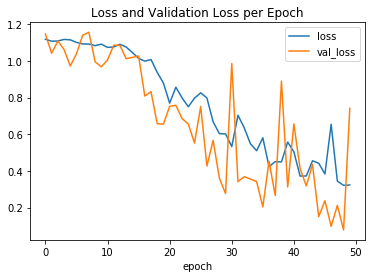

In [58]:
plt.plot(history.history['loss'], label='loss');
plt.plot(history.history['val_loss'], label='val_loss');
plt.xlabel('epoch');
plt.title('Loss and Validation Loss per Epoch')
plt.legend();
plt.savefig('loss_val_loss_mobilenet.png')

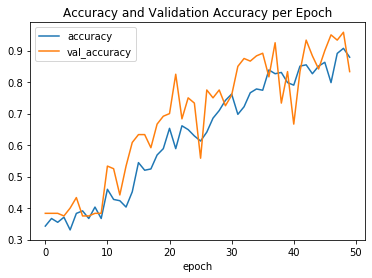

In [59]:
plt.plot(history.history['acc'], label='accuracy');
plt.plot(history.history['val_acc'], label='val_accuracy');
plt.xlabel('epoch');
plt.title('Accuracy and Validation Accuracy per Epoch')
plt.legend();
plt.savefig('acc_val_acc_mobilenet.png')